In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
from itertools import groupby

In [2]:
NB_WEEKS = 169

## Loading the data

In [3]:
# read xlsx file using pandas
df = pd.read_excel('/Users/cho-eungi/Practice/CSV/Tridge_Data_Science_Squad_Assignment_220331.xlsx', sheet_name='RawData')

# Initialize a stats dataframe for each product
df_stats = df[['product_id']]

df.head()

,product_id,2019-01-07 00:00:00,2019-01-14 00:00:00,2019-01-21 00:00:00,2019-01-28 00:00:00,2019-02-04 00:00:00,2019-02-11 00:00:00,2019-02-18 00:00:00,2019-02-25 00:00:00,2019-03-04 00:00:00,...,2022-01-24 00:00:00,2022-01-31 00:00:00,2022-02-07 00:00:00,2022-02-14 00:00:00,2022-02-21 00:00:00,2022-02-28 00:00:00,2022-03-07 00:00:00,2022-03-14 00:00:00,2022-03-21 00:00:00,2022-03-28 00:00:00
0,1,233000.0,233000.0,233000.0,233000.0,233000.0,233000.0,233000.0,233000.0,233000.0,...,223000.0,223000.0,223000.0,223000.0,223000.0,223000.0,223000.0,223000.0,223000.0,NaN
1,2,400000.0,400000.0,400000.0,400000.0,400000.0,400000.0,400000.0,400000.0,400000.0,...,713000.0,713000.0,713000.0,713000.0,713000.0,713000.0,713000.0,713000.0,713000.0,NaN
2,3,245000.0,245000.0,245000.0,245000.0,245000.0,245000.0,245000.0,245000.0,245000.0,...,220000.0,220000.0,220000.0,220000.0,220000.0,220000.0,220000.0,220000.0,220000.0,NaN
3,4,230000.0,230000.0,230000.0,230000.0,230000.0,230000.0,230000.0,230000.0,230000.0,...,217000.0,217000.0,213000.0,213000.0,213000.0,215250.0,216000.0,216000.0,216000.0,NaN
4,5,440000.0,440000.0,440000.0,440000.0,440000.0,440000.0,440000.0,440000.0,440000.0,...,700000.0,700000.0,700000.0,700000.0,700000.0,700000.0,700000.0,700000.0,700000.0,NaN


## Data quality

Time series is over 169 weeks.

### Completeness

In this section we will investigate the completeness of the data by answering the following questions:
- Is there a missing date in the columns?
- Is there a missing value in the rows?
- If there is a missing value, how many missing values? And is it normal?
- If there are too many missing values, is it still useful to use the data?

#### Missing values

We first check the number of rows with missing values, and how this number is distributed.

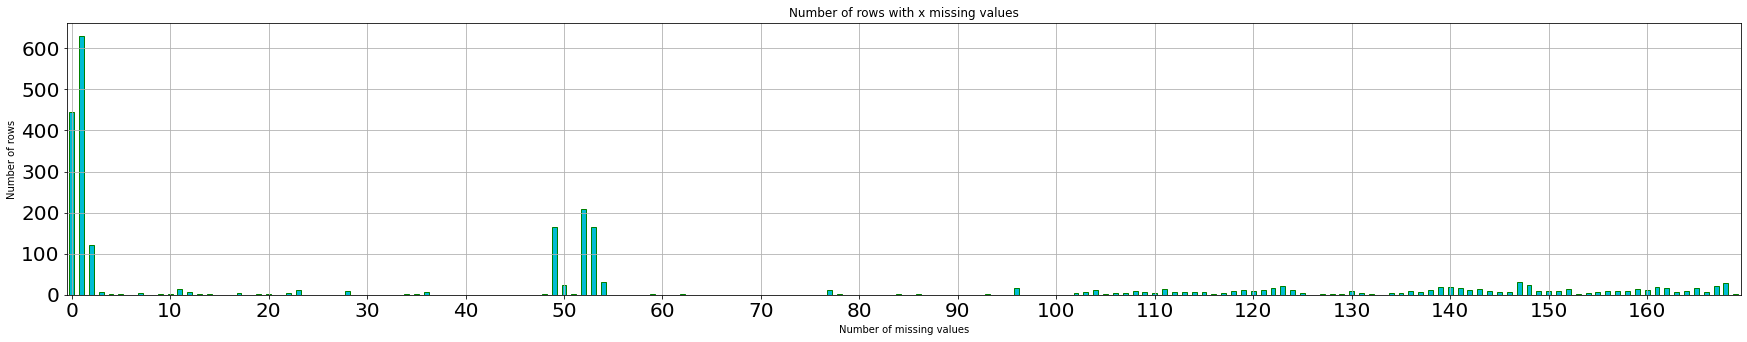

In [4]:
def plot_missing_values(data):
    count_serie = data.isnull().sum(axis=1)
    count_serie_groupby = count_serie.value_counts().sort_index()
    count_serie_groupby = count_serie_groupby.reindex(range(170), fill_value=0)
    count_serie_groupby.plot.bar(
        rot=0, figsize=(30, 5), title='Number of rows with x missing values', 
        fontsize=20, color='#00bcd4', edgecolor='g', linestyle='-', 
        legend=False, grid=True, xticks=range(0, 170, 10), xlabel='Number of missing values', ylabel='Number of rows'
    )

plot_missing_values(df)

In [5]:
count_serie = df.isna().sum(axis=1)

# Adding count of missing value in the stats dataframe
df_stats = df_stats.assign(missing_values_count=count_serie)

count_serie = count_serie[count_serie < (NB_WEEKS * 0.75)]
count_serie = count_serie.reset_index()
count_serie['product_id'] = count_serie['index'] + 1

df_enough_values = df[df['product_id'].isin(count_serie['product_id'].values)]
tmp = df_enough_values.isna().sum(axis=1)

df.shape[0] - df_enough_values.shape[0]

455

We can consider that if a product is missing more than 25% of the values, we can classify the data as "not representative". In our dataset, this represents **455 rows**.

On the histogram, we can see that there are many rows missing one or two values. For some of them, this corresponds to the last weeks of the period. We can easily think that the most recent data may take some time to be collected. Therefore, we can temporarily exclude these last two columns from our analysis, as this could be corrected by changing the data acquisition process.

(2125, 168)

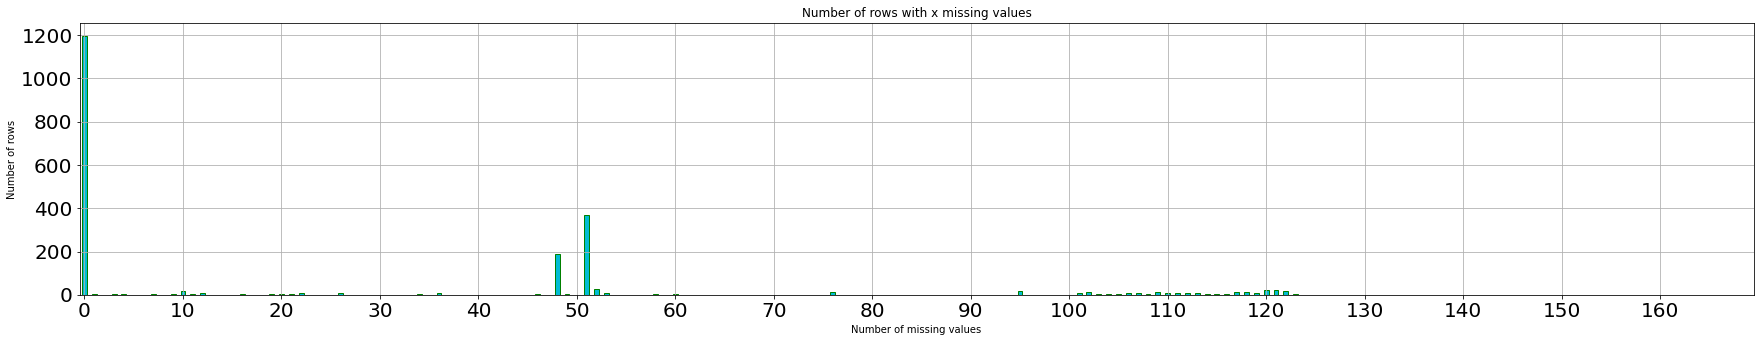

In [27]:
df_without_recent = df_enough_values.iloc[:, 0:-2]
plot_missing_values(df_without_recent)
df_without_recent.shape

Among the remaining rows, some are still missing a large number of values. In some cases, it appears that data for a specific product started to be collected after a certain date. This would explain why the first columns are missing but the rest are complete. 

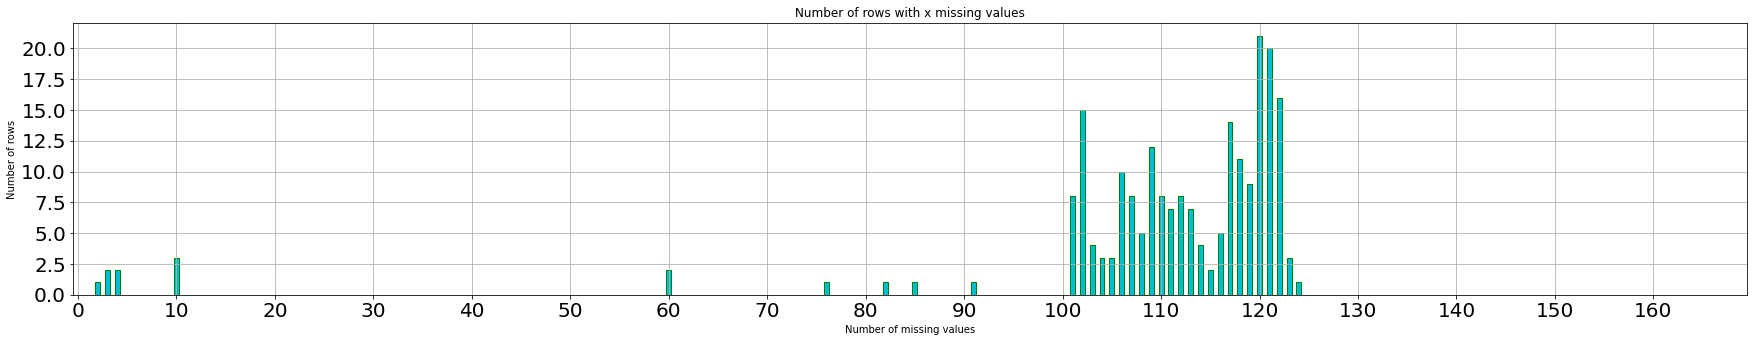

In [7]:
def is_row_missing_first_values(row):
    nb_null_values = row.isnull().sum()
    if row[1:nb_null_values + 1].isnull().sum() == nb_null_values:
        return True
    return False

df_without_recent['is_lagged_data'] = df_without_recent.apply(is_row_missing_first_values, axis=1)
plot_missing_values(df_without_recent[df_without_recent['is_lagged_data'] == False])

A product for which data started to be collected after a certain date will have fewer values in the time window of the dataset, but is still representative of the price evolution of the product.

By removing all these "lagged acquisition" products from our analysis, we can now see the few rows that have many missing values.

In [8]:
df_without_recent[df_without_recent['is_lagged_data'] == False].shape

(218, 169)

We are now left with **221 lines** for which we have to choose whether to keep them or not.

Among these rows, there are some that are "only" missing 2 to 10 values. In this case, it would be possible to interpolate the missing data. As for the other rows, we can consider them as "not representative".

### Timeliness

Now let's check that the date columns are correctly filled in, and correctly formatted.

In [9]:
# Excluding first column: product_id
dates = [_ for _ in df.columns[1:]]

# Dates if there's no missing value
theorical_dates = [dates[0] + timedelta(days=7 * i) for i in range(len(dates))]

print(f"Dates are increasing correctly: {dates == theorical_dates}")

Dates are increasing correctly: True


### Validity

In this section we will investigate whether the values in the dataset are plausible. To do this, we will look at :
- The range of values, and whether any of them are inconsistent with others.
- The distribution of values.
- Anomalies in the data set.

As data processing is not part of the quality assessment, we will only focus on a part of the data set that we have previously defined as relevant.

In [10]:
df_validity = df_without_recent.drop(columns=['is_lagged_data'])

df_validity.shape

(2125, 168)

#### Confidence bands
We are going to compute confidence bands for each time serie in the dataset that has no missing values.

In [11]:
def outlier(values, moving_average_len=12, sigma=2, diplay_plot=False):
    """ Outlier detection using moving average """
    average = np.arange(len(values)).astype(np.float32)
    for i in np.arange(len(average)):
        average[i] = np.mean(values[np.max([0,i - moving_average_len]): (i + 1)])

    N = values - average
    std = np.std(N)

    outlier_indexes = []
    for i in range(len(values)):
        if values[i] > (average[i] + sigma * std) or values[i] < (average[i] - sigma * std):
            outlier_indexes.append(i)

    if diplay_plot:
        plt.figure(figsize=(15, 6), dpi=80)

        plt.plot(values)
        plt.plot(average)
        plt.plot(average - std * sigma, '--', color='#ff0000')
        plt.plot(average + std * sigma, '--', color='#ff0000')
        plt.xlabel('Time (weeks)')
        plt.ylabel('Price')
        plt.title('Outlier detection (sigma=' + str(sigma) + ')')
        plt.legend(['Values', 'Moving average', 'Lower bound', 'Upper bound'])

        plt.show()

    return len(outlier_indexes)

In [12]:
df_validity['outlier_count_2_std'] = df_validity.apply(lambda row: outlier(row[1:].values[~np.isnan(row.values[1:])], sigma=2), axis=1)

df_stats = df_stats.merge(
    df_validity[['product_id', 'outlier_count_2_std']],
    how='left',
    left_on='product_id',
    right_on='product_id'
)

df_validity.drop(['outlier_count_2_std'], axis=1, inplace=True)

<AxesSubplot:title={'center':'Number of rows with x outliers'}, xlabel='Number of outliers', ylabel='Number of rows'>

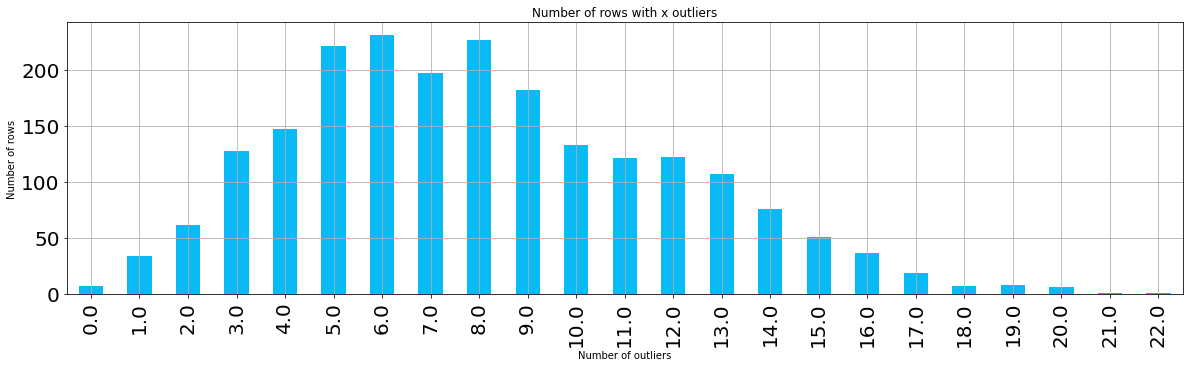

In [13]:
df_stats['outlier_count_2_std'].value_counts().sort_index().plot.bar(
    figsize=(20, 5), title='Number of rows with x outliers',
    fontsize=20, color='#09baf5', linestyle='-', legend=False,
    grid=True, xlabel='Number of outliers', ylabel='Number of rows')

We now have a better understanding of the range of values and the distribution of values. Let us look at the distribution of time series with outliers.

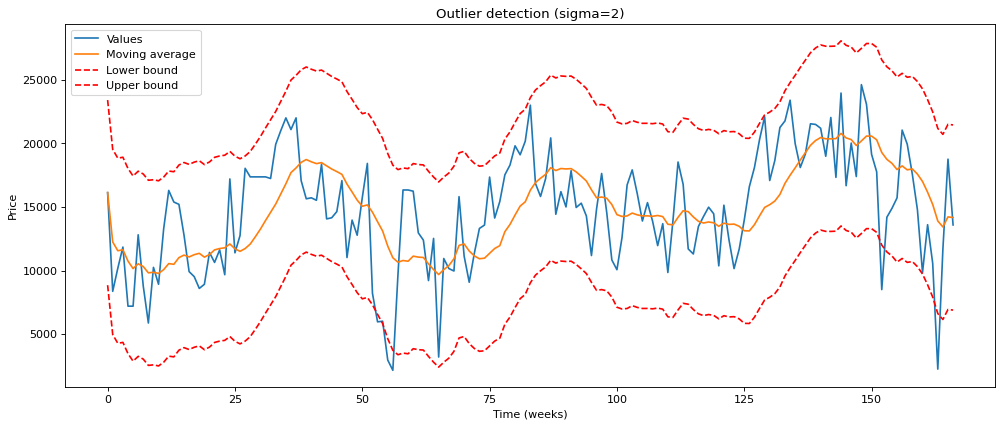

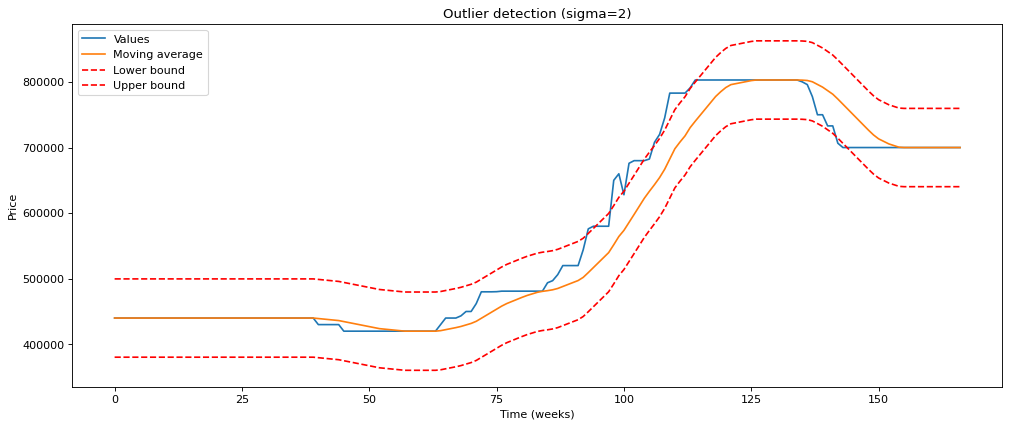

18

In [14]:
product_id_few_outliers = df_stats[df_stats['outlier_count_2_std'] == 5]['product_id'].values[0]
product_id_many_outliers = df_stats[df_stats['outlier_count_2_std'] == 18]['product_id'].values[0]

v_low = df_validity[df_validity['product_id'] == product_id_few_outliers].values[0, 1:]
v_low = v_low[~np.isnan(v_low)]
outlier(v_low, diplay_plot=True)

v_high = df_validity[df_validity['product_id'] == product_id_many_outliers].values[0, 1:]
v_high = v_high[~np.isnan(v_high)]
outlier(v_high, diplay_plot=True)

We can see that most of the time series have outliers. As this data set is about product prices, it seems normal that prices can suddenly increase or decrease. It might be interesting to see if this is the case when we increase the confidence band.

In [15]:
df_validity['outlier_count_3_std'] = df_validity.apply(lambda row: outlier(row[1:].values[~np.isnan(row.values[1:])], sigma=3), axis=1)

df_stats = df_stats.merge(
    df_validity[['product_id', 'outlier_count_3_std']],
    how='left',
    left_on='product_id',
    right_on='product_id'
)

df_validity.drop(['outlier_count_3_std'], axis=1, inplace=True)
df_stats['outlier_count_3_std'].value_counts().sort_index()

0.0     549
1.0     556
2.0     413
3.0     289
4.0     128
5.0      81
6.0      56
7.0      32
8.0      12
9.0       8
10.0      1
Name: outlier_count_3_std, dtype: int64

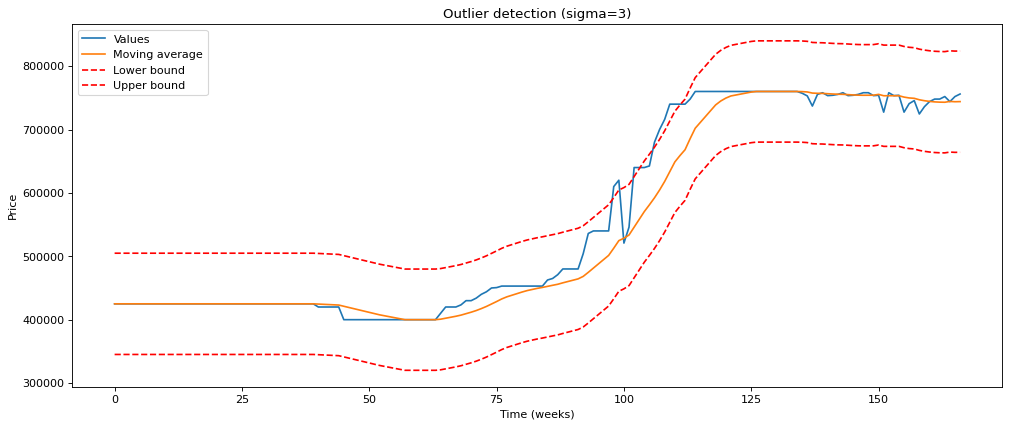

10

In [16]:
product_id = df_stats[df_stats['outlier_count_3_std'] == 10]['product_id'].values[0]

v = df_validity[df_validity['product_id'] == product_id].values[0, 1:]
v = v[~np.isnan(v)]
outlier(v, diplay_plot=True, sigma=3)

Rapid changes in value are usually an anomaly in time series. However, in the context of this data set, the price increase is plausible. Further investigation could be done by studying the stationarity of the time series.
This is part of the modelling and will not be done in this notebook.

#### Uniqueness

We will check for duplicates in the data set. Two time series with very close values are possible if the products depend on each other, but exactly identical values are unlikely.

In [17]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of rows without duplicates: {df.drop_duplicates().shape[0]}")

print(f"Number of products: {df['product_id'].shape[0]}")
print(f"Number of products without duplicates: {df['product_id'].nunique()}")

Number of rows: 2580
Number of rows without duplicates: 2580
Number of products: 2580
Number of products without duplicates: 2580


#### Unit & Measurement

In [18]:
def get_count_different_decimals(row):
    s = set()

    # Excluding product_id column
    for v in row[1:]:
        s.add(str(v)[::-1].find('.'))

    return len(s)

df_stats['count_different_decimals'] = df.apply(get_count_different_decimals, axis=1)
df_stats.head()

,product_id,missing_values_count,outlier_count_2_std,outlier_count_3_std,count_different_decimals
0,1,1,10.0,5.0,2
1,2,1,16.0,2.0,3
2,3,1,14.0,6.0,2
3,4,1,12.0,6.0,2
4,5,1,18.0,4.0,3


Due to the lack of information, we cannot check the consistency of the measurement currency. Even assuming that the currency is the same for all time series, without the product description we cannot assess the meaning of the values.

However, we can check the accuracy of the measurement. It appears that within the same row, prices have a different number of decimal places. This should not have a huge impact when forming the model, but to be consistent it would be appreciated if the values were formatted in the same way.

#### Steps in data

Looking at the data set, we can clearly see that for some time series the price remains the same for several weeks, and sometimes make "steps" in the time series.
Therefore, we will calculate the maximum number of consecutive identical values for each time series.

In [19]:
def has_step(row):
    values = row[1:]
    return max([sum(1 for _ in g if _ != np.nan) for _, g in groupby(values)])
    
df_stats['longest_step'] = df.apply(has_step, axis=1)
df_stats.sort_values(by='longest_step', ascending=False).head(10)

,product_id,missing_values_count,outlier_count_2_std,outlier_count_3_std,count_different_decimals,longest_step
2576,2577,2,0.0,0.0,2,167
2455,2456,1,15.0,9.0,2,141
2468,2469,1,15.0,9.0,2,92
2465,2466,1,12.0,5.0,2,87
101,102,1,12.0,6.0,2,83
2476,2477,1,14.0,8.0,2,76
100,101,1,13.0,4.0,2,75
2454,2455,1,14.0,7.0,2,74
2207,2208,1,19.0,9.0,2,73
2466,2467,1,12.0,5.0,2,73


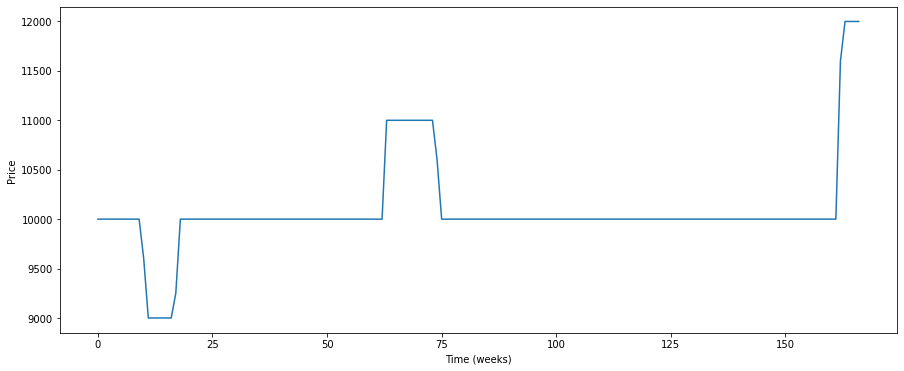

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(df_validity[df_validity['product_id'] == 2466].values[0, 1:])
plt.xlabel('Time (weeks)')
plt.ylabel('Price')

plt.show()

It appears that some time series have many steps. This may be due to the fact that the price of the product does not change very often or that the data has not been acquired for a long time.
Even if some time series have almost no missing values, the presence of large steps reduces their relevance. For example, modelling the price of the time series displayed above would be quite difficult.

The length of the longest step in a time series could be another criterion for keeping or removing the time series from the dataset.

#### Volatility

Instead of looking at the standard deviation of the time series, we can calculate the weekly financial return. Since it is based on the value of week $n-1$, it remains relative.

In [21]:
def get_volatility(row):
    v = row[1:].values
    v = v[~np.isnan(v)]
    financial_weekly_return = [(v[i] - v[i - 1]) / v[i - 1] for i in range(1, len(v))]
    return np.std(financial_weekly_return)

df_validity['volatility'] = df_validity.apply(get_volatility, axis=1).sort_values(ascending=False)

df_stats = df_stats.merge(
    df_validity[['product_id', 'volatility']],
    how='left',
    left_on='product_id',
    right_on='product_id'
)

df_stats[['product_id', 'volatility']].sort_values(by='volatility', ascending=False).head(10)

,product_id,volatility
2441,2442,1.408817
2446,2447,1.375616
2445,2446,1.375616
2579,2580,1.274033
2578,2579,1.160422
2452,2453,1.144803
2004,2005,1.096176
1083,1084,1.036045
1660,1661,0.993090
1062,1063,0.992883


Product price volatility: 1.4084055033868794


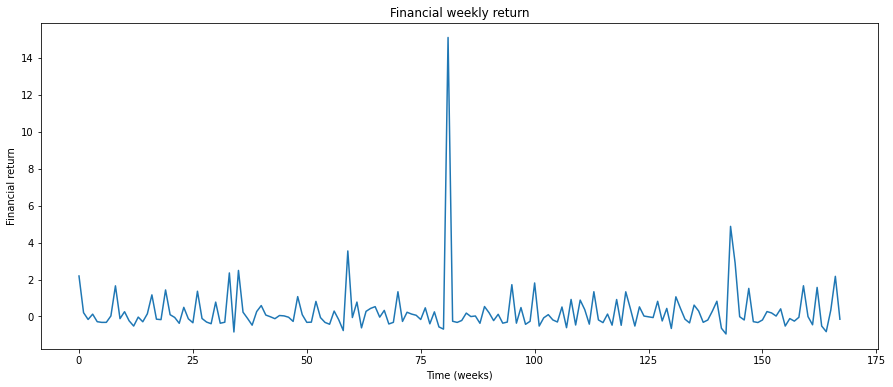

In [22]:
v = df[df['product_id'] == 2442].values[0, 1:]
v = v[~np.isnan(v)]
financial_weekly_return = [(v[i] - v[i - 1]) / v[i - 1] for i in range(1, len(v))]

print(f"Product price volatility: {np.std(financial_weekly_return)}")

plt.figure(figsize=(15, 6))
plt.plot(financial_weekly_return)
plt.xlabel('Time (weeks)')
plt.ylabel('Financial return')
plt.title('Financial weekly return')
plt.show()

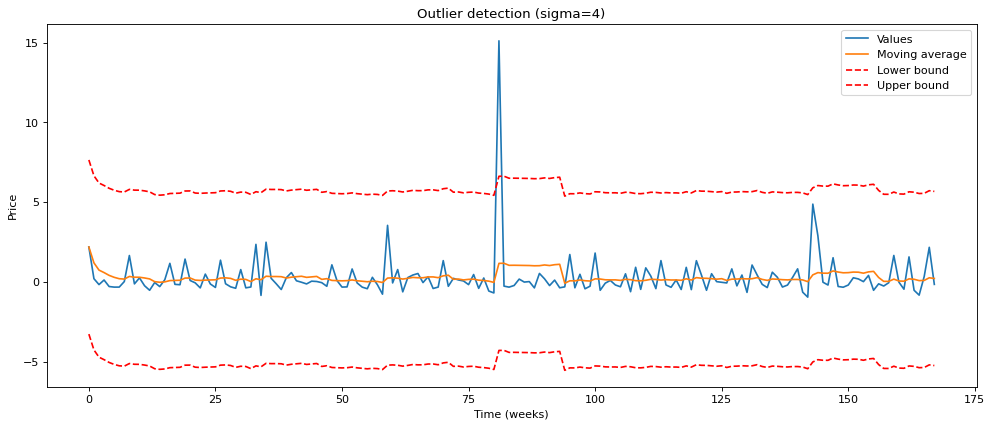

1

In [23]:
outlier(financial_weekly_return, diplay_plot=True, sigma=4)

This method allows us to calculate the volatility of the time series for each product by calculating the standard deviation of the time series of financial returns. By classifying products by their volatility, it is easier to find anomalies in the time series using confidence bands for example.

In [24]:
def get_financial_return_outlier(row):
    v = row[1:].values
    v = v[~np.isnan(v)]
    financial_weekly_return = [(v[i] - v[i - 1]) / v[i - 1] for i in range(1, len(v))]
    return outlier(financial_weekly_return, sigma=4)

df_validity['outlier_count_financial_return'] = df_validity.apply(get_financial_return_outlier, axis=1)

df_stats = df_stats.merge(
    df_validity[['product_id', 'outlier_count_financial_return']],
    how='left',
    left_on='product_id',
    right_on='product_id'
)

df_stats[['product_id', 'outlier_count_financial_return']].sort_values(by='outlier_count_financial_return', ascending=False).head(10)

,product_id,outlier_count_financial_return
1999,2000,4.0
1717,1718,4.0
52,53,4.0
445,446,4.0
449,450,4.0
433,434,3.0
2405,2406,3.0
51,52,3.0
1601,1602,3.0
969,970,3.0


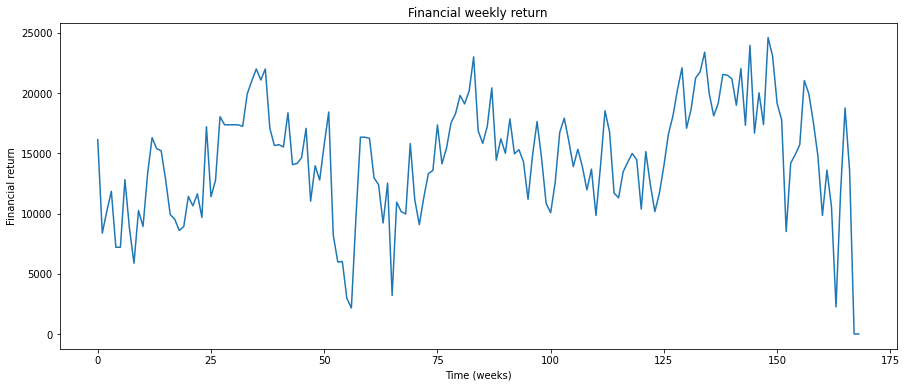

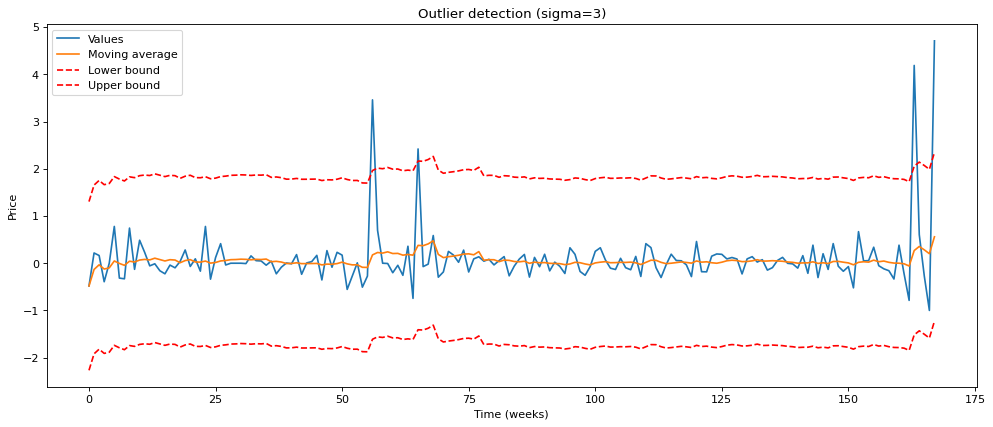

4

In [25]:

v = df_validity[df_validity['product_id'] == 41].values[0, 1:]
v = v[~np.isnan(v)]
financial_weekly_return = [(v[i] - v[i - 1]) / v[i - 1] for i in range(1, len(v))]

plt.figure(figsize=(15, 6))
plt.plot(v)
plt.xlabel('Time (weeks)')
plt.ylabel('Financial return')
plt.title('Financial weekly return')
plt.show()
outlier(financial_weekly_return, sigma=3, diplay_plot=True)

To conclude, the following is a list of features that we will calculate for each time series. Each of these features can be used to discard or retain a product from the data set.

In [26]:
df_stats.head()

,product_id,missing_values_count,outlier_count_2_std,outlier_count_3_std,count_different_decimals,longest_step,volatility,outlier_count_financial_return
0,1,1,10.0,5.0,2,60,0.009348,1.0
1,2,1,16.0,2.0,3,34,0.019592,1.0
2,3,1,14.0,6.0,2,51,0.013479,1.0
3,4,1,12.0,6.0,2,45,0.016408,1.0
4,5,1,18.0,4.0,3,40,0.016155,1.0
